In [1]:
from typing import Dict, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import cluster, mixture, decomposition

import cv2

In [2]:
# STEM_real = np.load('./data/3DStack13-1-exp.npy')
# decoded_imgs = np.load('./data/3DStack13-1-dec.npy')
# lattice_coord = np.load('./data/3DStack13-1-coord.npy', allow_pickle=True)[()]

In [3]:
# C_cnt = 0
# for i in lattice_coord.keys():
#     coord_arr = lattice_coord[i]
#     inner_cnt = len(coord_arr) - np.count_nonzero(coord_arr[:, -1])
#     C_cnt += inner_cnt


# print(f"There are {C_cnt} carbon atoms in all STEM frames")

In [4]:
# plt.imshow(decoded_imgs[0].transpose(2, 0, 1)[2], "gnuplot")
# plt.axis("off")


In [5]:
# # Create a larger figure for 9 subplots
# fig = plt.figure(figsize=(15, 17), dpi=100)

# # Add column titles
# col_titles = ["Experimental", "DCNN output", "Atomic coordinates"]
# for idx, title in enumerate(col_titles):
#     fig.text(0.166 + idx * 0.33, 0.9, title, ha="center", fontsize=16)

# # Loop through different time frames
# for idx, i in enumerate([20, 30, 40]):
#     # Process image and get coordinates
#     d_img = np.uint8(decoded_imgs[i] * 255)
#     d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
#     coord_Si = lattice_coord[i][np.where(lattice_coord[i][:, 2] == 1)][:, 0:2]
#     coord_C = lattice_coord[i][np.where(lattice_coord[i][:, 2] == 0)][:, 0:2]

#     # Add row title (time step)
#     fig.text(
#         0.05,
#         0.75 - idx * 0.3,
#         f"t = {i}",
#         rotation=90,
#         ha="right",
#         va="center",
#         color="yellow",
#         fontsize=16,
#     )

#     # Create three subplots for each time frame
#     ax1 = fig.add_subplot(3, 3, idx * 3 + 1)
#     ax1.imshow(STEM_real[i, :, :, 0], vmin=0, vmax=0.3, cmap="gray")
#     ax1.axis("off")

#     ax2 = fig.add_subplot(3, 3, idx * 3 + 2)
#     ax2.imshow(d_img, cmap="jet", interpolation="gaussian")
#     ax2.axis("off")

#     ax3 = fig.add_subplot(3, 3, idx * 3 + 3)
#     ax3.scatter(coord_Si[:, 1], coord_Si[:, 0], c="red", s=1)
#     ax3.scatter(coord_C[:, 1], coord_C[:, 0], c="blue", s=1)
#     ax3.imshow(STEM_real[i, :, :, 0], cmap="gray")
#     ax3.axis("off")

# plt.tight_layout()  # Adjust spacing between subplots
# # Add some padding at the top for column titles
# plt.subplots_adjust(top=0.9)
# plt.show()

In [6]:
class imlocal:
    """
    STEM image local crystallography class
    highly ported from atomai https://github.com/pycroscopy/atomai/tree/master
    """

    def __init__(
        self,
        network_output: np.ndarray,
        coord_class_dict_all: Dict[int, np.ndarray],
        window_size: int = None,
        coord_class: int = 0,
    ) -> None:
        self.network_output = network_output
        self.nb_classes = network_output.shape[-1]
        self.coord_all = coord_class_dict_all
        self.coord_class = float(coord_class)
        self.r = window_size
        (self.imgstack, self.imgstack_com, self.imgstack_frames) = (
            self.extract_subimages_()
        )
        self.d0, self.d1, self.d2, self.d3 = self.imgstack.shape

    def get_imgstack(
        self,
        imgdata: np.ndarray,
        coord: np.ndarray,
        r: int,
    ) -> Tuple[np.ndarray]:

        img_cr_all = []
        com = []
        for c in coord:
            cx = int(np.around(c[0]))
            cy = int(np.around(c[1]))
            if r % 2 != 0:
                img_cr = np.copy(
                    imgdata[
                        cx - r // 2 : cx + r // 2 + 1, cy - r // 2 : cy + r // 2 + 1
                    ]
                )
            else:
                img_cr = np.copy(
                    imgdata[cx - r // 2 : cx + r // 2, cy - r // 2 : cy + r // 2]
                )
            if img_cr.shape[0:2] == (int(r), int(r)) and not np.isnan(img_cr).any():
                img_cr_all.append(img_cr[None, ...])
                com.append(c[None, ...])
        if len(img_cr_all) == 0:
            return None, None
        img_cr_all = np.concatenate(img_cr_all, axis=0)
        com = np.concatenate(com, axis=0)
        return img_cr_all, com

    def extract_subimages(
        self,
        imgdata: np.ndarray,
        coordinates: Union[Dict[int, np.ndarray], np.ndarray],
        window_size: int,
        coord_class: int = 0,
    ) -> Tuple[np.ndarray]:

        if isinstance(coordinates, np.ndarray):
            coordinates = np.concatenate(
                (coordinates, np.zeros((coordinates.shape[0], 1))), axis=-1
            )
            coordinates = {0: coordinates}
        if np.ndim(imgdata) == 2:
            imgdata = imgdata[None, ..., None]
        subimages_all, com_all, frames_all = [], [], []
        for i, (img, coord) in enumerate(zip(imgdata, coordinates.values())):
            coord_i = coord[np.where(coord[:, 2] == coord_class)][:, :2]
            stack_i, com_i = self.get_imgstack(img, coord_i, window_size)
            if stack_i is None:
                continue
            subimages_all.append(stack_i)
            com_all.append(com_i)
            frames_all.append(np.ones(len(com_i), int) * i)
        if len(subimages_all) > 0:
            subimages_all = np.concatenate(subimages_all, axis=0)
            com_all = np.concatenate(com_all, axis=0)
            frames_all = np.concatenate(frames_all, axis=0)
        return subimages_all, com_all, frames_all

    def extract_subimages_(self) -> Tuple[np.ndarray]:

        imgstack, imgstack_com, imgstack_frames = self.extract_subimages(
            self.network_output, self.coord_all, self.r, self.coord_class
        )
        return imgstack, imgstack_com, imgstack_frames

In [7]:
# s = imlocal(np.sum(decoded_imgs[..., :-1], -1)[..., None], lattice_coord, 24, 0)
# imgstack, imgstack_com, imgstack_frm = s.imgstack, s.imgstack_com, s.imgstack_frames

In [8]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split

# imstack_train, imstack_test = train_test_split(
#     imgstack,
#     test_size=0.15,
#     shuffle=True,
#     random_state=42,
# )
# print(
#     f"train stack shape: {imstack_train.shape},\ntest stack shape: {imstack_test.shape}"
# )

# train_dataset, val_dataset = TensorDataset(
#     torch.from_numpy(
#         imstack_train.transpose(0, 3, 1, 2).reshape(len(imstack_train), -1)
#     )
# ), TensorDataset(
#     torch.from_numpy(imstack_test.transpose(0, 3, 1, 2).reshape(len(imstack_test), -1)),
# )

# train_loader = DataLoader(
#     dataset=train_dataset,
#     batch_size=100,
#     shuffle=True,
#     num_workers=4,
#     persistent_workers=True,
# )

# val_loader = DataLoader(
#     dataset=val_dataset,
#     batch_size=100,
#     shuffle=False,
#     num_workers=4,
#     persistent_workers=True,
# )

In [16]:
from rVAE import rVAE
import yaml

import platform
import torch


def is_mps():
    return platform.system() == "Darwin" and torch.backends.mps.is_available()


def is_cuda():
    return torch.cuda.is_available()


def get_device():
    if is_mps():
        return torch.device("mps")
    elif is_cuda():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def load_config(config_path):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


config = load_config("./config/rVAE.yaml")

rvae = rVAE(
    in_dim=576,
    z_dim=config["model"]["z_dim"],
    hidden_dim=config["model"]["hidden_dim"],
    num_layers=config["model"]["num_layers"],
    translation=config["prior"][
        "translation"
    ],  ## this requires explicitly set to be true
    dx_prior=config["prior"]["dx_prior"],
    theta_prior=config["prior"]["theta_prior"],
    optim=config["train"]["optim_type"],
    epoch=config["train"]["epochs"],
    init_lr=config["train"]["learning_rate"],
    activation=config["model"]["activation"],
    device="cpu",
)

checkpoints = r"checkpoints/rVAE/train/2025-01-08-12-57-22/E50_gen.pth"
rvae.load_state_dict(torch.load(checkpoints), strict=False)

<All keys matched successfully>

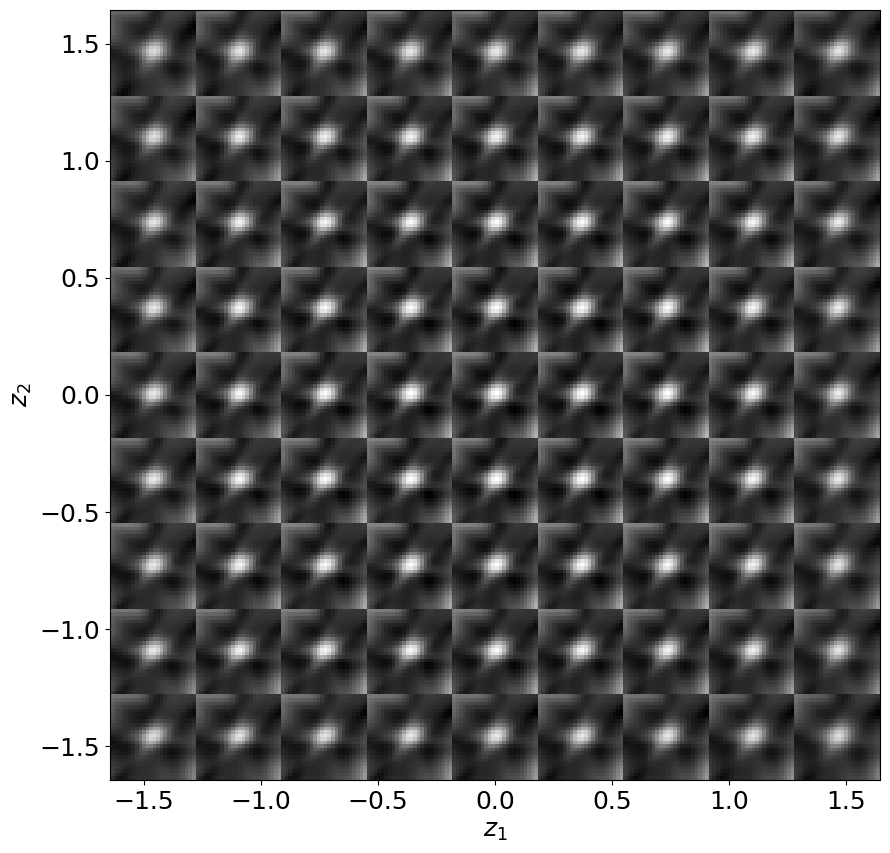

array([[0.14877012, 0.11640778, 0.09420688, ..., 0.24226967, 0.27374643,
        0.30770791],
       [0.17077157, 0.14362933, 0.11719204, ..., 0.23349454, 0.2646662 ,
        0.29765147],
       [0.17872667, 0.1602204 , 0.13929959, ..., 0.22235742, 0.25271106,
        0.28424805],
       ...,
       [0.23793983, 0.22000104, 0.20522164, ..., 0.15050076, 0.13470788,
        0.11368984],
       [0.24248244, 0.23049083, 0.22199492, ..., 0.16483553, 0.15350312,
        0.13870969],
       [0.25645509, 0.25080508, 0.24815568, ..., 0.17523348, 0.16625278,
        0.15560256]])

In [17]:
rvae.eval()
rvae.manifold2d(cmap = "gray")

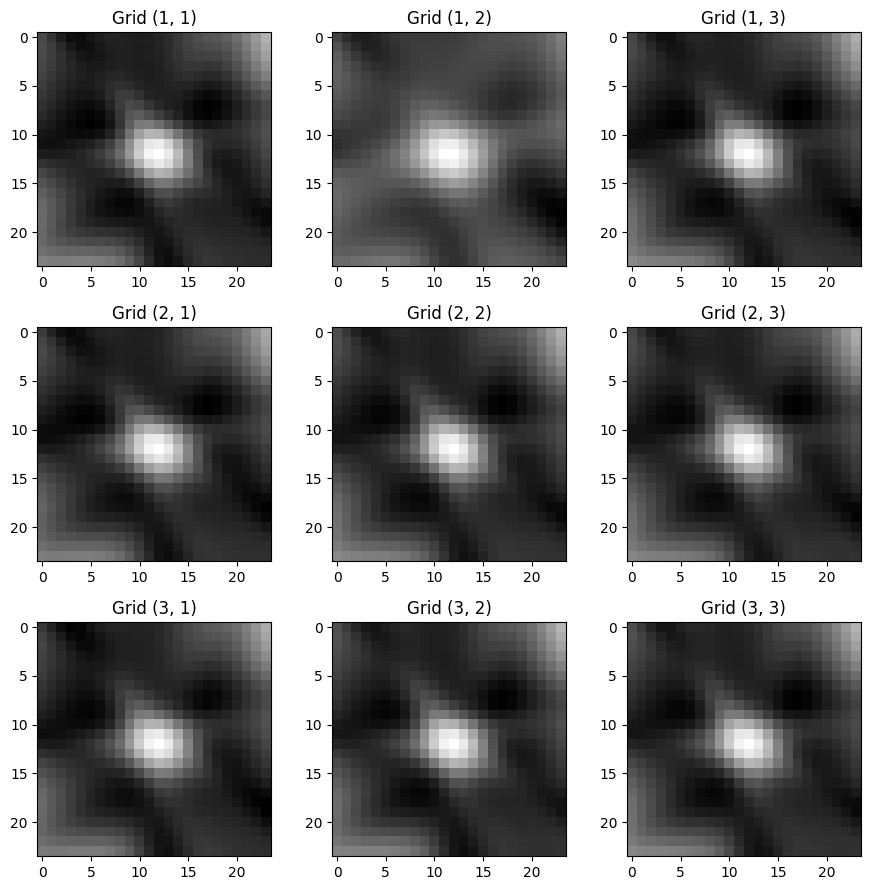

In [18]:
import matplotlib.pyplot as plt
import numpy as np

samples = rvae.sample(9, "cpu")
samples = samples.view(9, 24, 24).detach().numpy()

# 创建 3x3 的九宫格
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # figsize 设定图形大小

# 使用 axes 绘制每个格子的内容
for i in range(3):
    for j in range(3):
        # 获取当前格子
        ax = axes[i, j]

        # 在每个格子中绘制内容，这里用随机数据绘制示例图
        ax.imshow(samples[i * 3 + j], cmap="gray")

        # 设置标题
        ax.set_title(f"Grid ({i+1}, {j+1})")

# 调整布局，使得图像不重叠
plt.tight_layout()

# 显示九宫格
plt.show()